Import

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

Ouverture du fichier csv de data 

In [18]:

df = pd.read_csv("../Data/e_commerce_shopper_behaviour_and_lifestyle.csv")
df.head(10)

,user_id,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,has_children,...,cart_items_average,checkout_abandonments_per_month,purchase_conversion_rate,app_usage_frequency,notification_response_rate,account_age_months,last_purchase_date,social_sharing_frequency,premium_subscription,return_rate
0,1,56,Female,Germany,Suburban,90860,Self-employed,Associate Degree,Single,0,...,10,2,62,7,74,19,2025-06-22,6,1,50
1,2,69,Male,Japan,Suburban,35423,Unemployed,Bachelor,Single,1,...,5,7,54,5,23,8,2026-07-25,3,0,37
2,3,46,Female,India,Urban,21467,Self-employed,Associate Degree,Married,1,...,3,3,33,7,12,13,2026-02-26,6,0,53
3,4,32,Male,Canada,Urban,41770,Self-employed,Bachelor,Widowed,0,...,5,9,26,4,19,9,2026-10-27,7,0,98
4,5,60,Female,Japan,Urban,183882,Employed,Associate Degree,Widowed,1,...,8,0,18,7,30,3,2026-06-23,3,0,86
5,6,25,Female,India,Suburban,127857,Self-employed,Associate Degree,In a relationship,0,...,6,5,89,0,27,3,2026-04-11,3,0,84
6,7,78,Female,Germany,Urban,62804,Student,Bachelor,Widowed,1,...,5,6,98,6,44,9,2026-02-14,5,0,34
7,8,38,Male,USA,Rural,72818,Retired,High School,Divorced,1,...,3,8,95,6,83,6,2026-09-27,4,0,90
8,9,56,Male,USA,Urban,107156,Unemployed,Bachelor,Married,1,...,3,9,69,0,66,3,2026-08-29,1,0,98
9,10,75,Non-binary,France,Suburban,11158,Employed,Master,In a relationship,0,...,2,0,28,6,6,5,2025-07-13,0,1,49


Je vois qu'on a des colonnes qu'on pourra encoder

In [6]:

print("Nombre de doublons :", df.duplicated().sum())

print("Valeurs nulles par colonne :\n", df.isnull().sum())

Nombre de doublons : 0
Valeurs nulles par colonne :
 user_id                            0
age                                0
gender                             0
country                            0
urban_rural                        0
income_level                       0
employment_status                  0
education_level                    0
relationship_status                0
has_children                       0
household_size                     0
occupation                         0
ethnicity                          0
language_preference                0
device_type                        0
weekly_purchases                   0
monthly_spend                      0
cart_abandonment_rate              0
review_writing_frequency           0
average_order_value                0
preferred_payment_method           0
coupon_usage_frequency             0
loyalty_program_member             0
referral_count                     0
product_category_preference        0
shopping_time_of_day  

Aucune valeur null ni doublon

Verification outliers

In [17]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

for col in colonnes_numeriques:
    moyenne = df[col].mean()
    ecart_type = df[col].std()
    outliers = df[(df[col] < moyenne - 3 * ecart_type) | (df[col] > moyenne + 3 * ecart_type)]
    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
income_level: 0 outliers
has_children: 0 outliers
household_size: 0 outliers
weekly_purchases: 0 outliers
monthly_spend: 0 outliers
review_writing_frequency: 0 outliers
average_order_value: 0 outliers
coupon_usage_frequency: 0 outliers
loyalty_program_member: 0 outliers
referral_count: 0 outliers
weekend_shopper: 0 outliers
browse_to_buy_ratio: 0 outliers
return_frequency: 0 outliers
brand_loyalty_score: 0 outliers
environmental_consciousness: 0 outliers
health_conscious_shopping: 0 outliers
travel_frequency: 0 outliers
hobby_count: 0 outliers
social_media_influence_score: 0 outliers
reading_habits: 0 outliers
exercise_frequency: 0 outliers
sleep_quality: 0 outliers
physical_activity_level: 0 outliers
mental_health_score: 0 outliers
daily_session_time_minutes: 0 outliers
product_views_per_day: 0 outliers
ad_views_per_day: 0 outliers
ad_clicks_per_day: 0 outliers
wishlist_items_count: 0 outliers
cart_items_average: 0 outliers
checkout_abandonments_per_month: 0 outliers
p

pas d'outliers


In [ ]:

if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

suppresssion colonner inutile

Matrice de corrélation

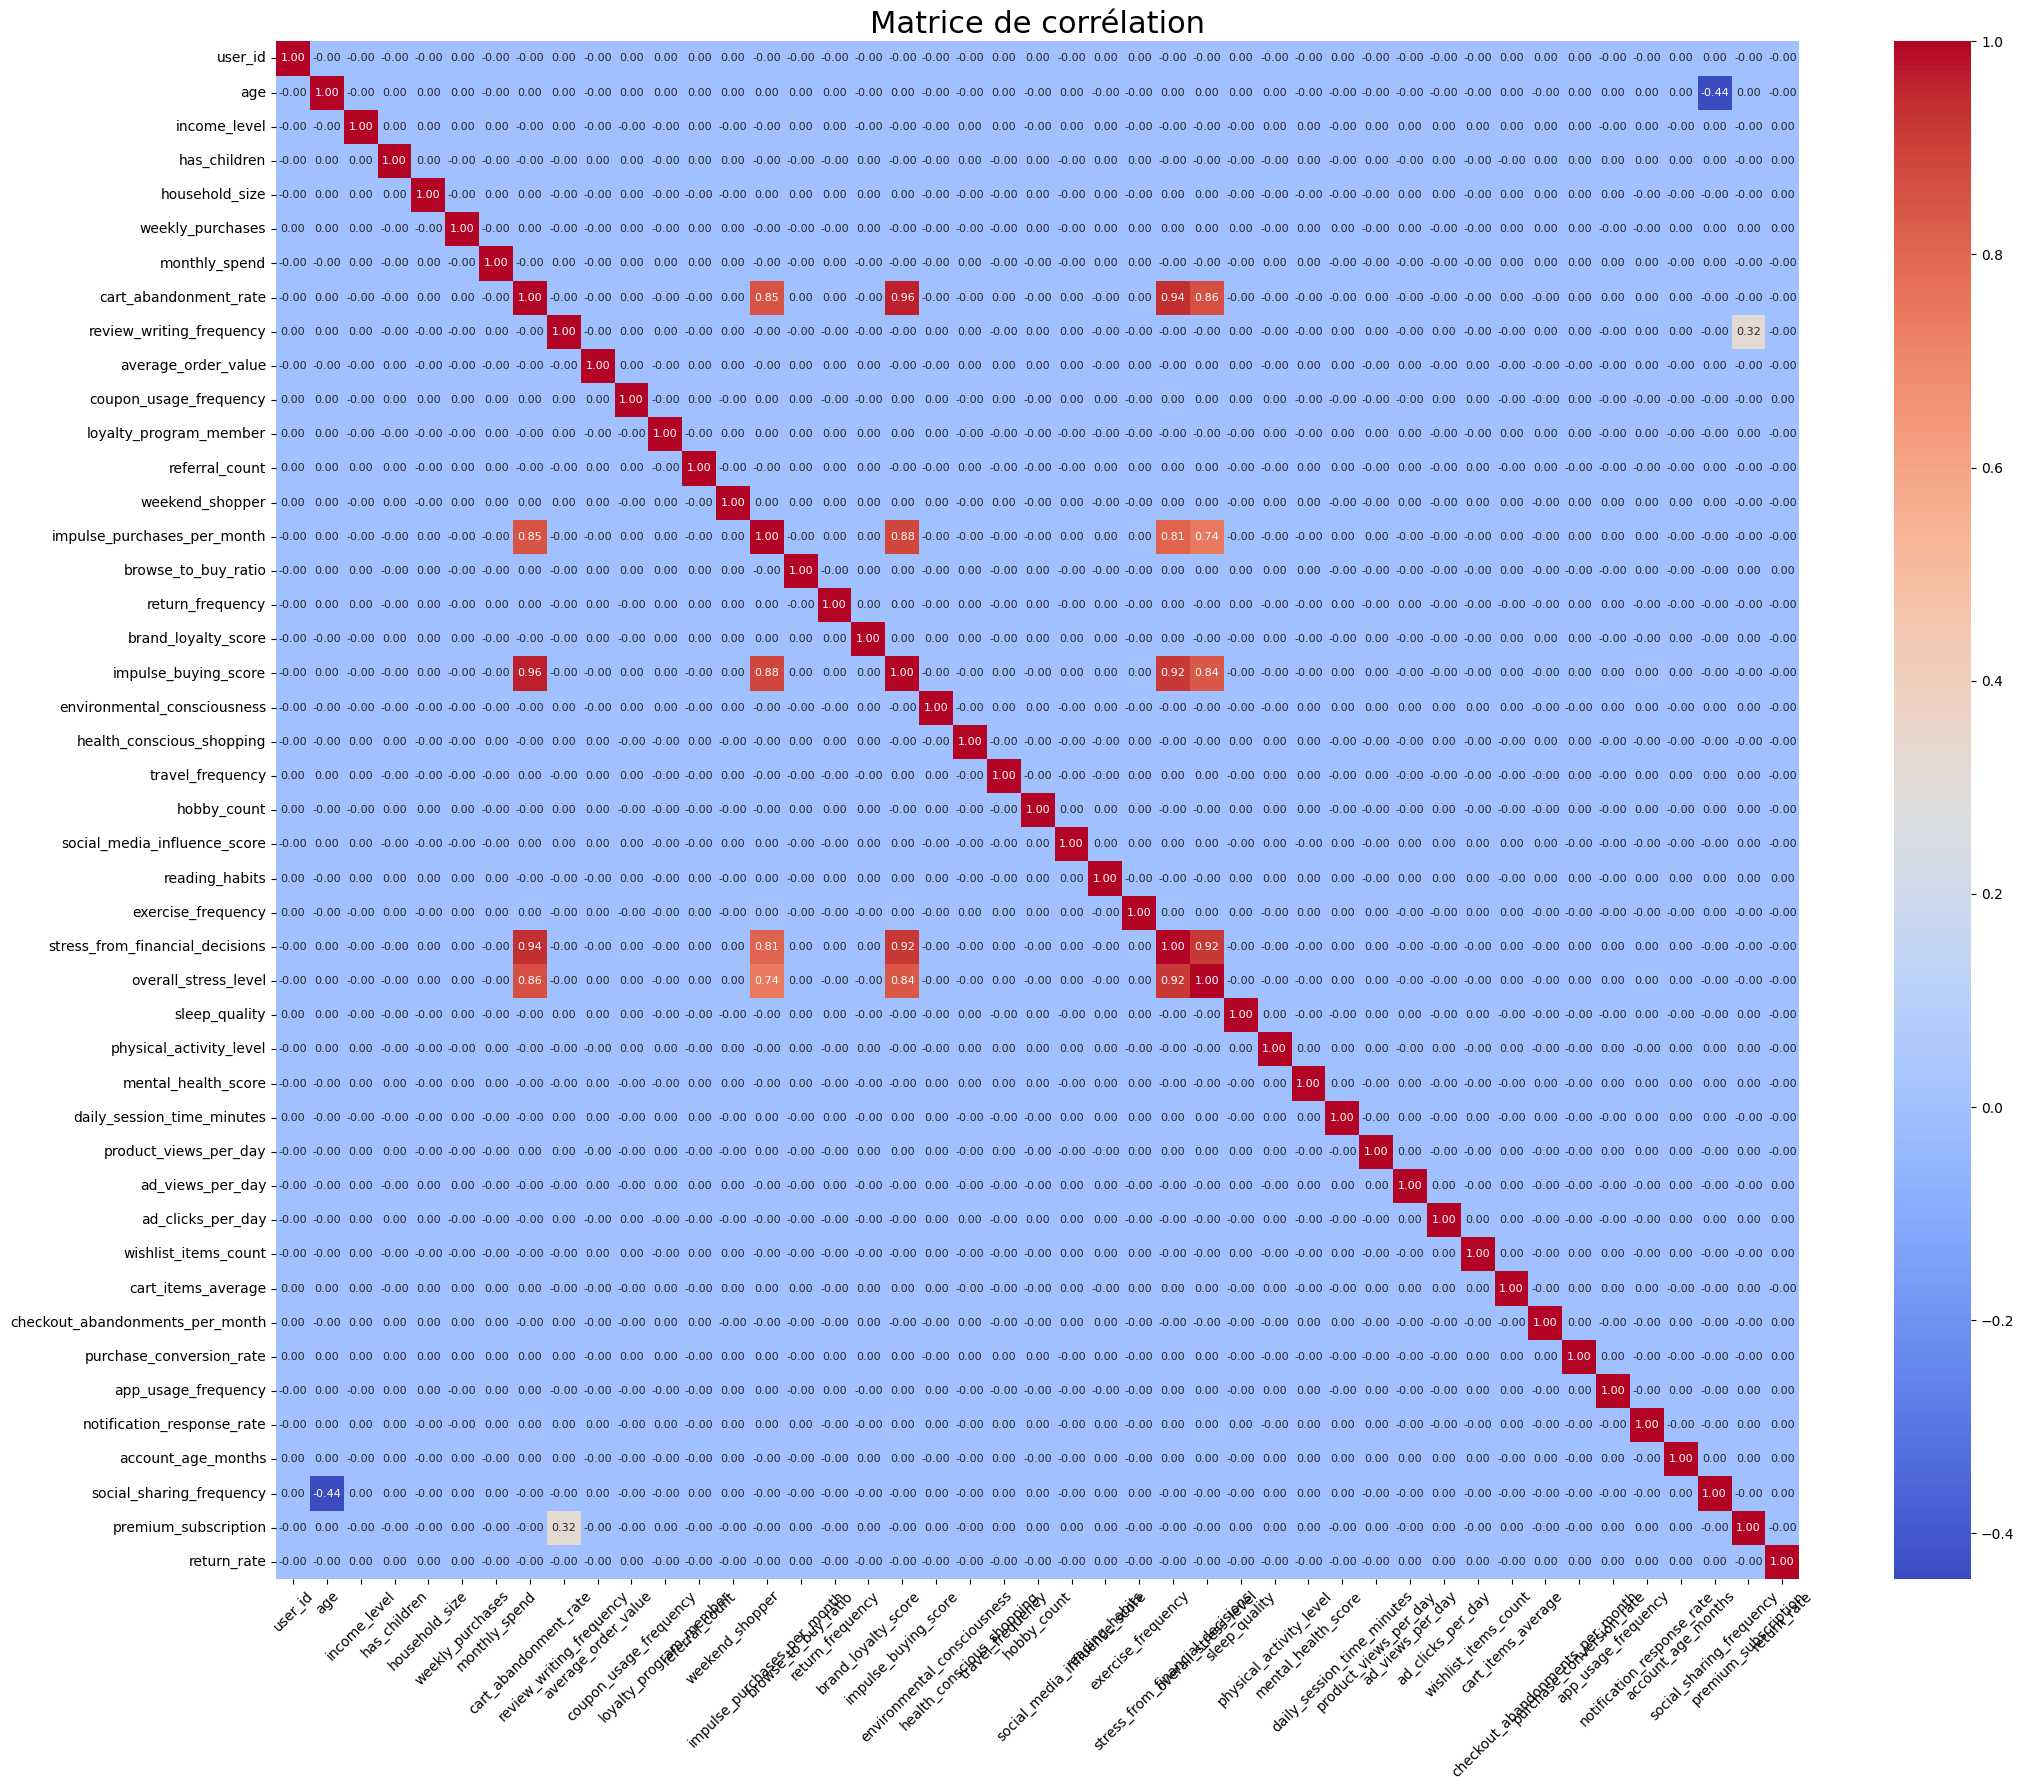

In [19]:
plt.figure(figsize=(22, 18))  
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8}  
)
plt.title("Matrice de corrélation", fontsize=22)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()  
plt.show()

On voie des colonne qui on de forte corrélation entre elle 

On va voir la répartition des données 

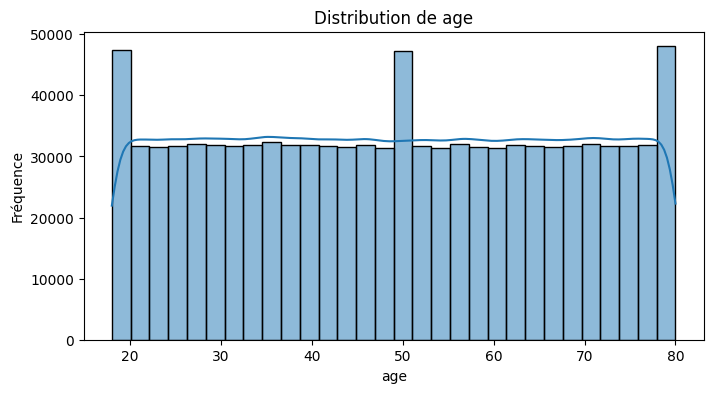

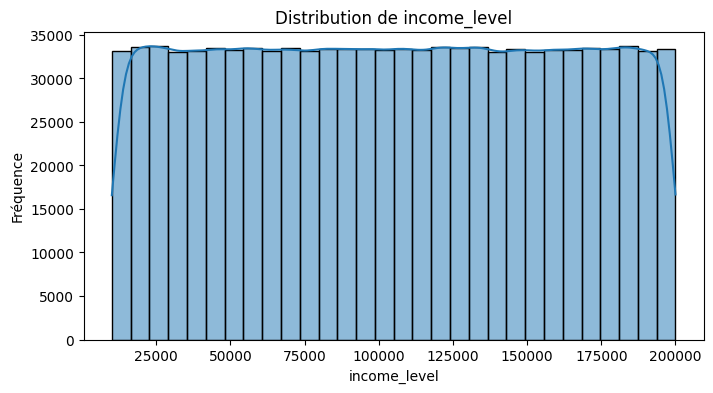

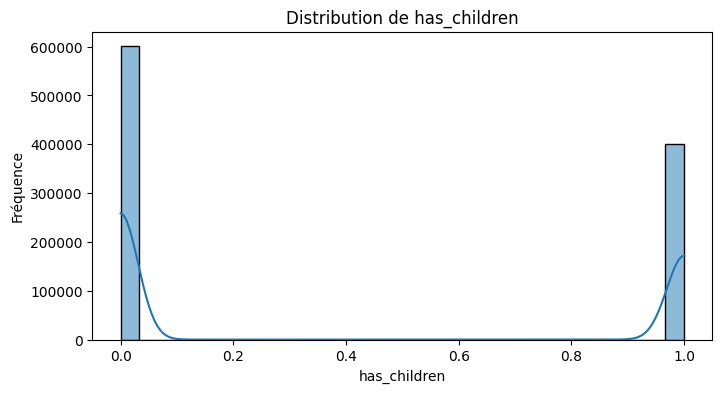

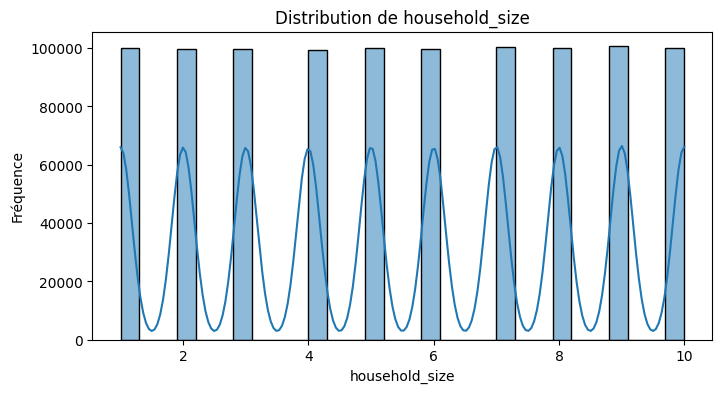

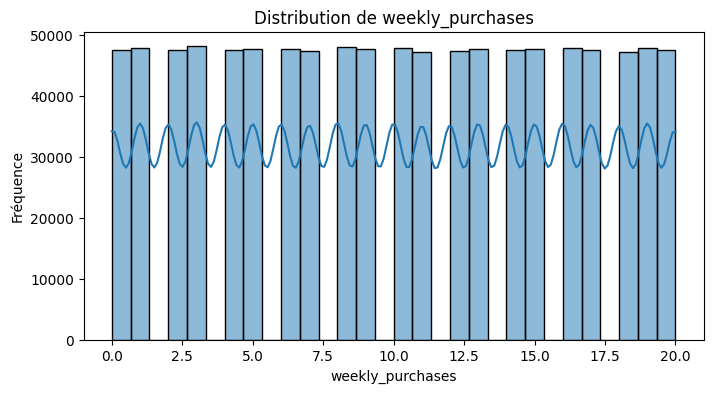

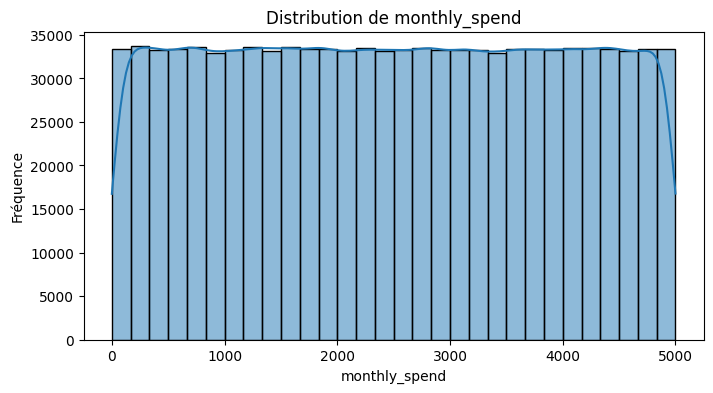

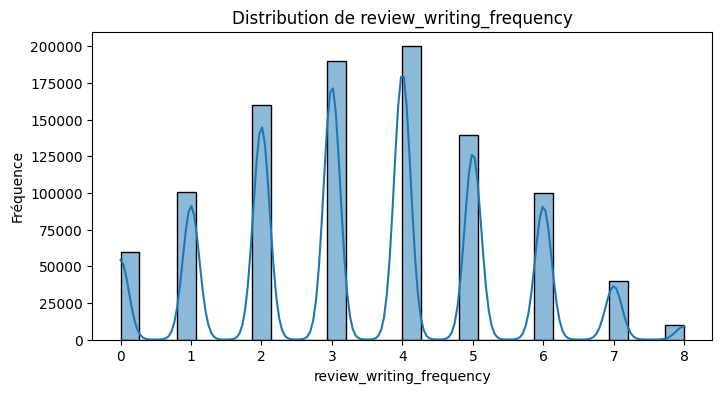

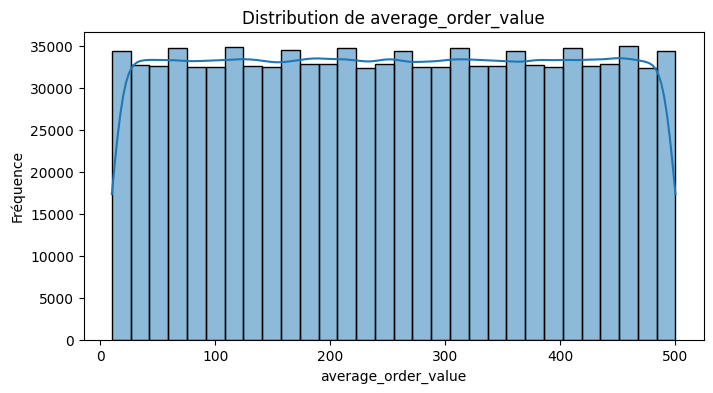

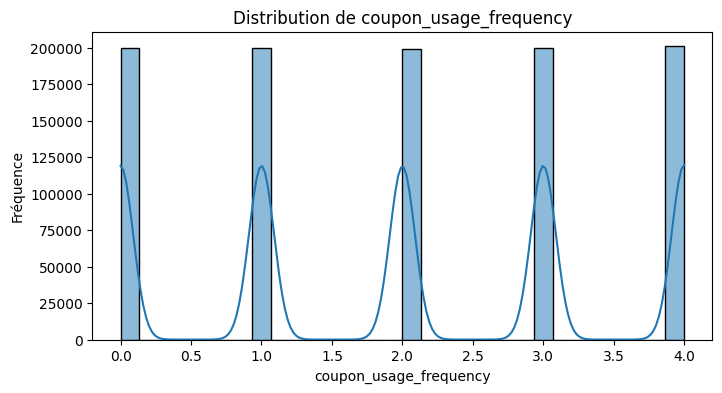

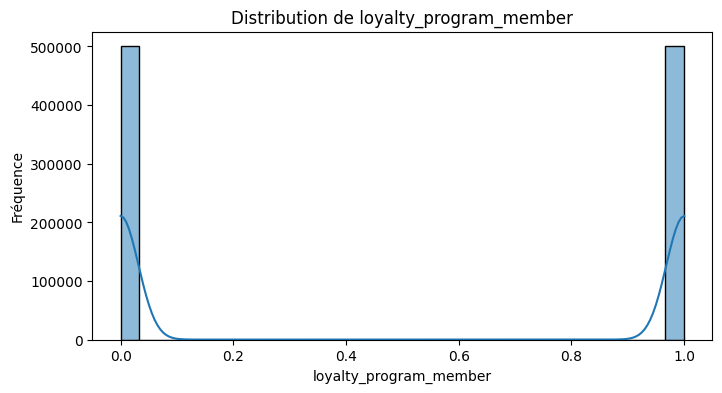

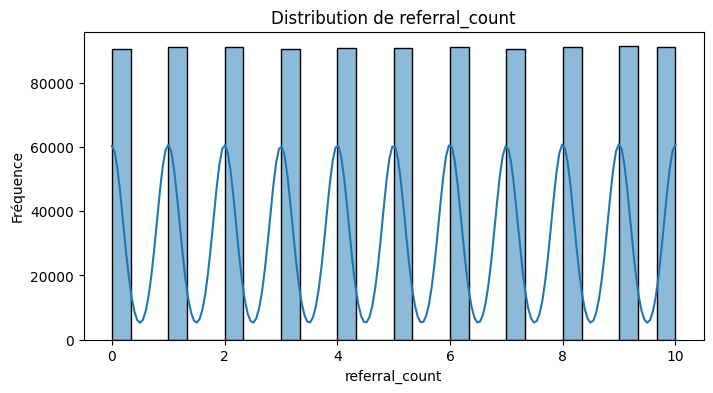

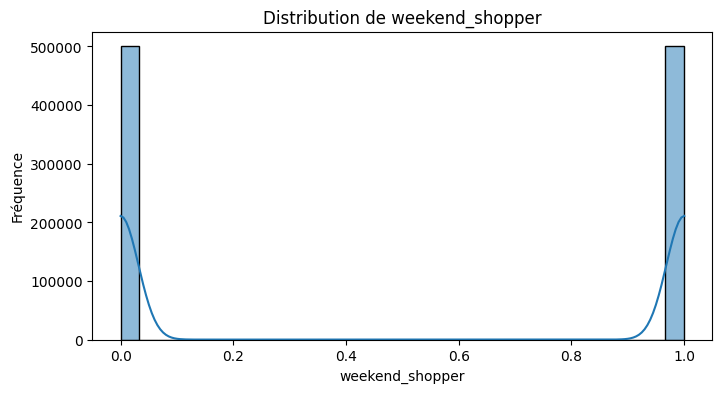

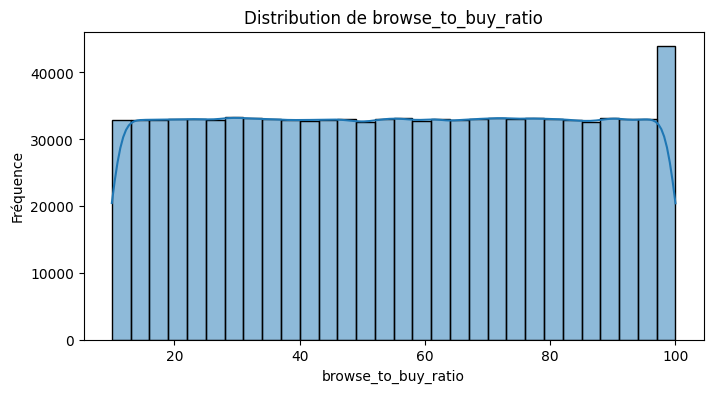

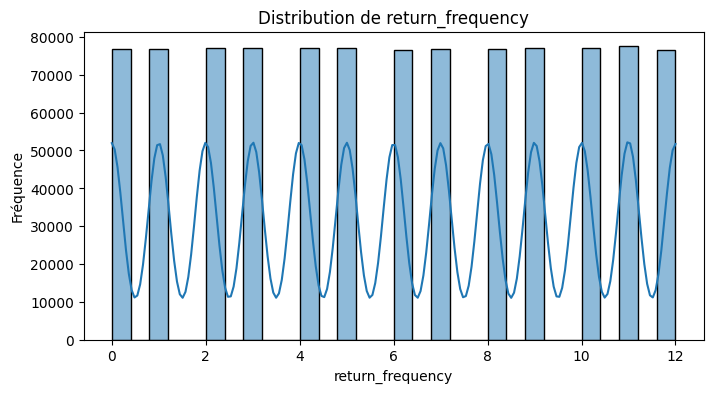

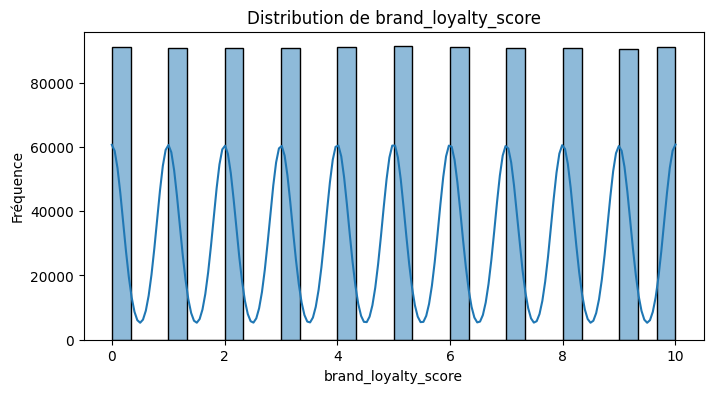

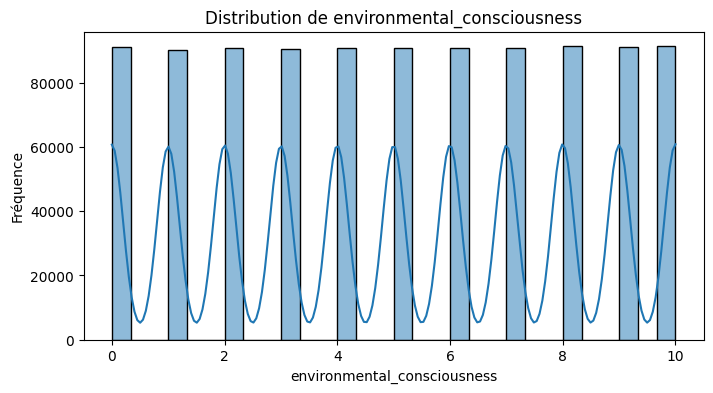

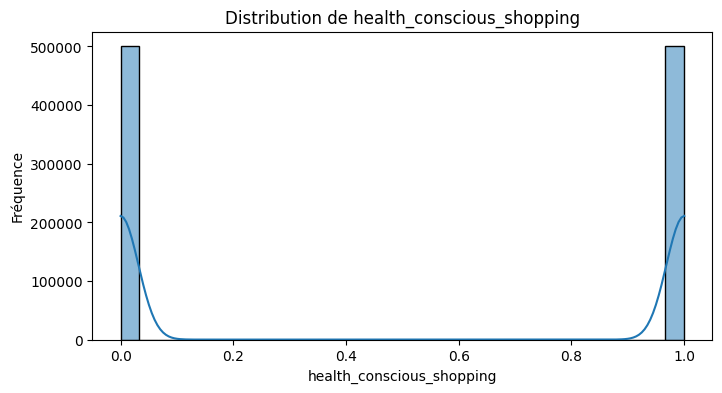

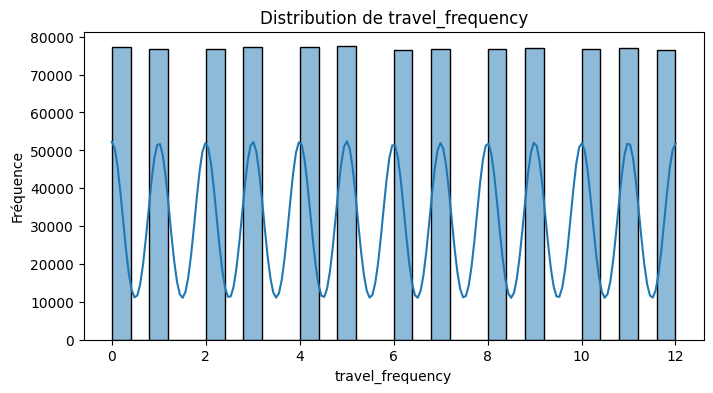

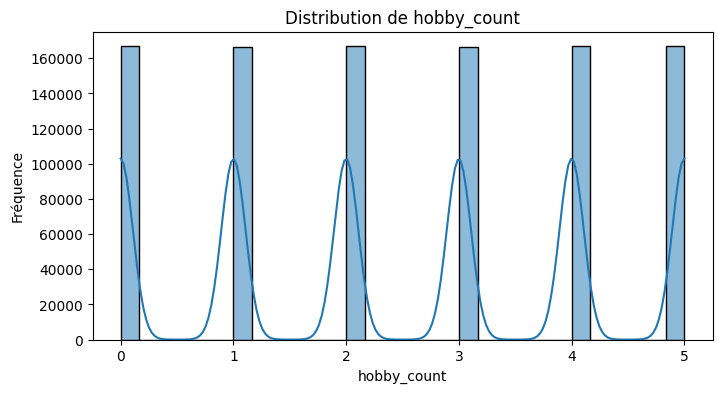

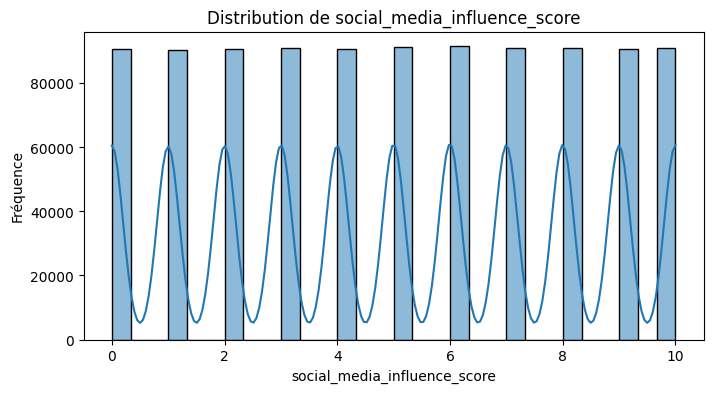

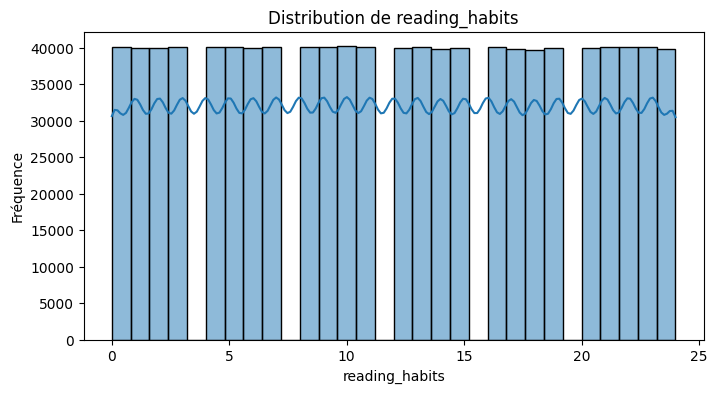

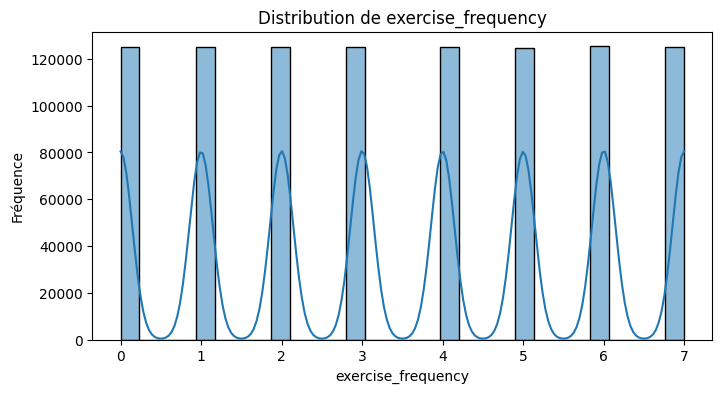

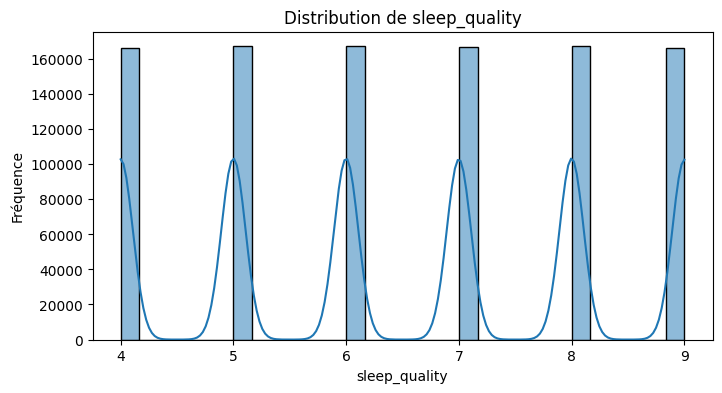

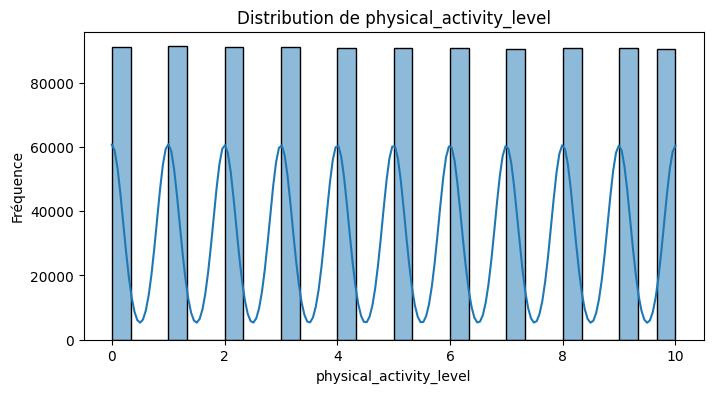

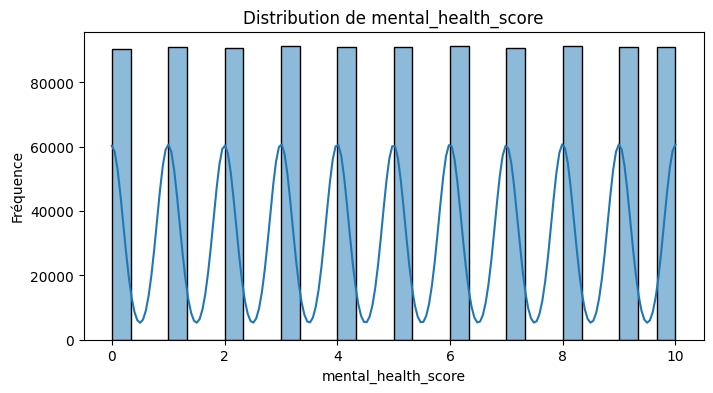

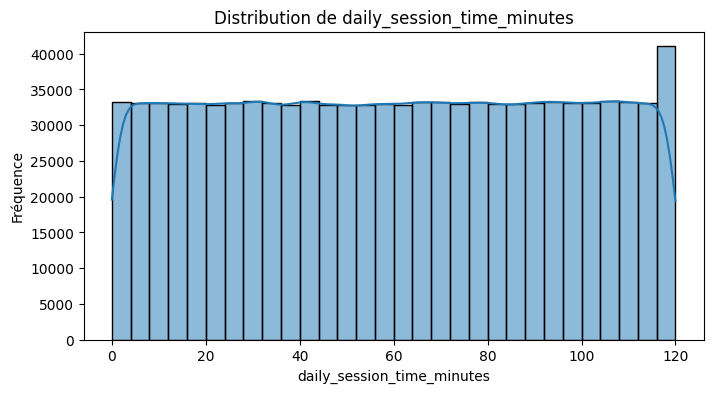

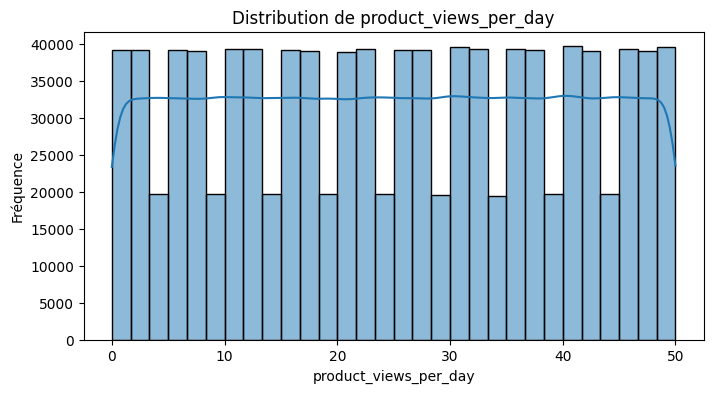

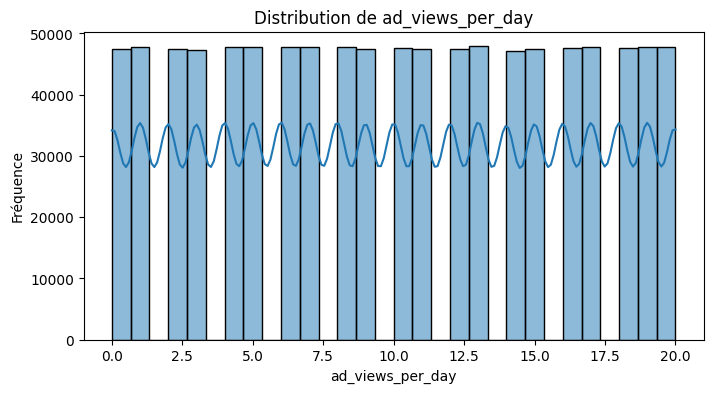

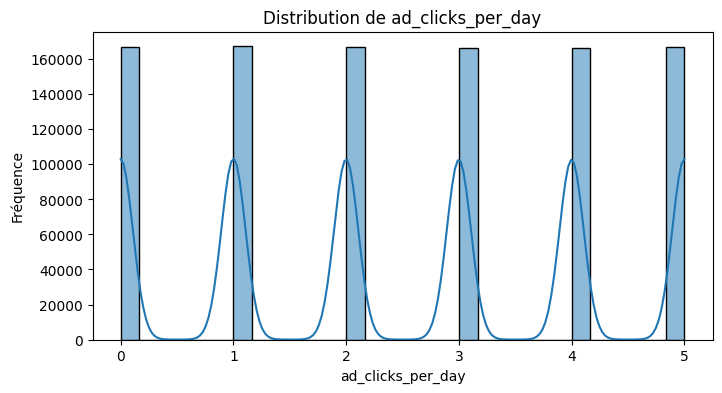

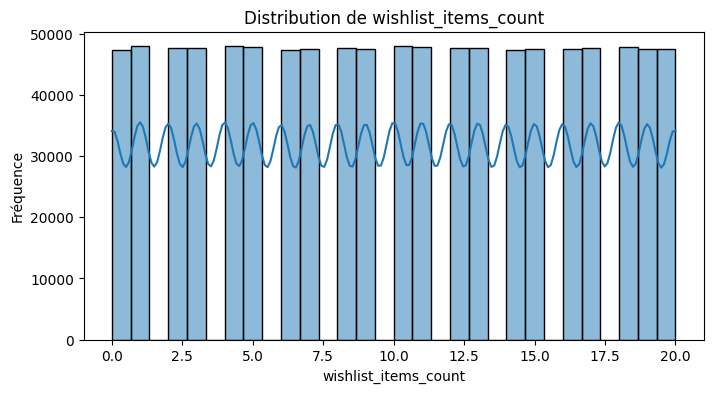

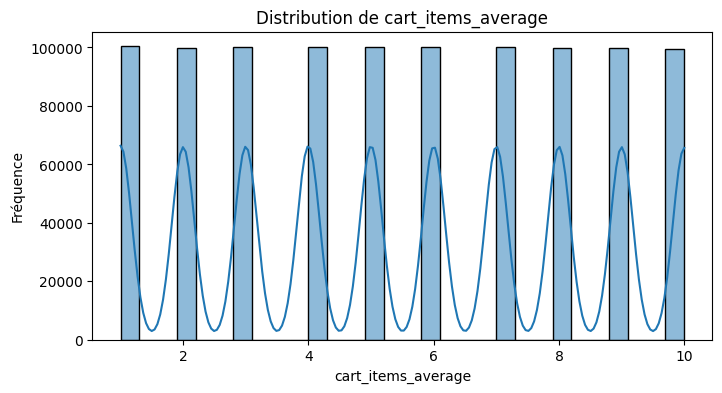

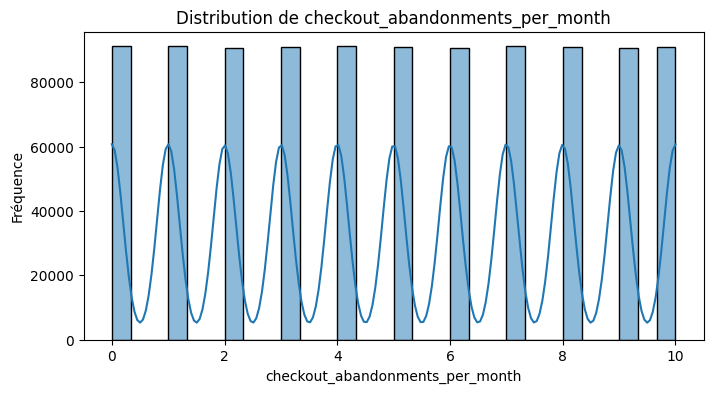

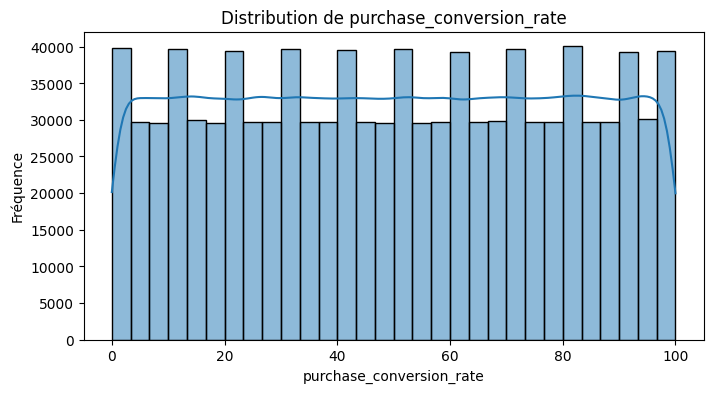

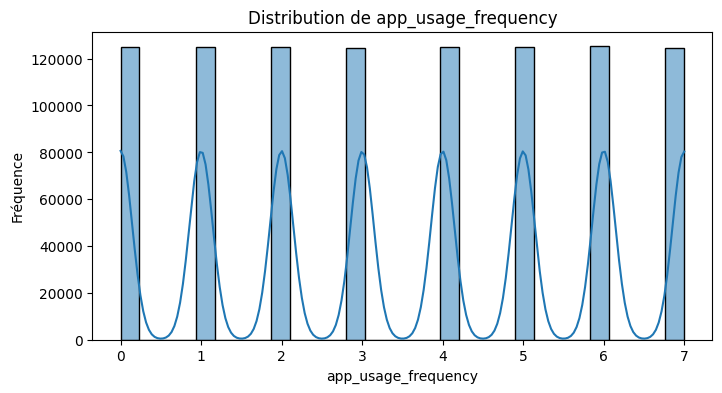

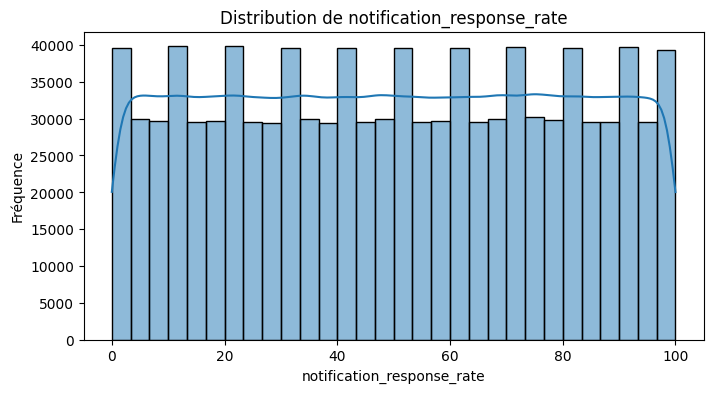

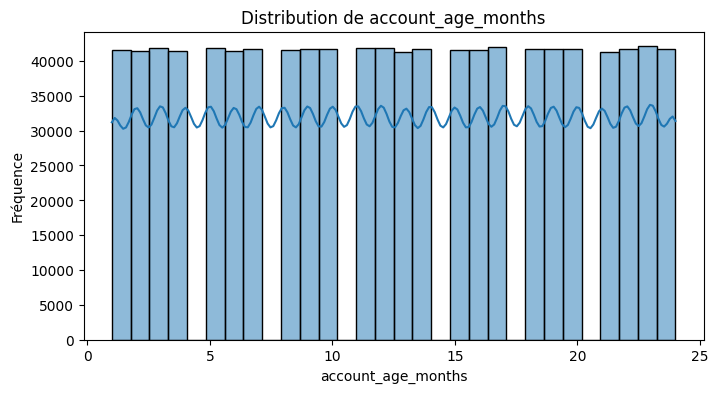

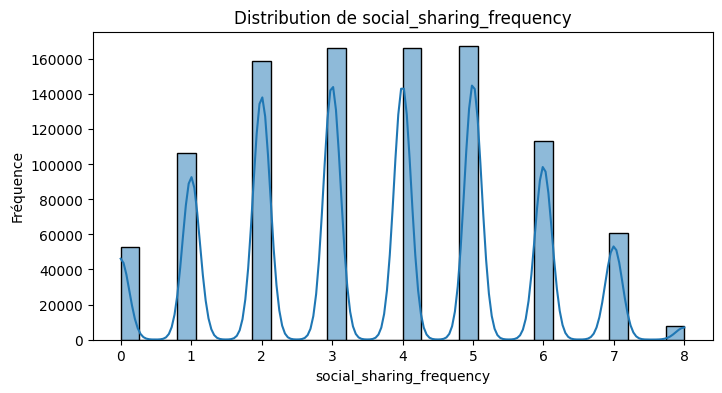

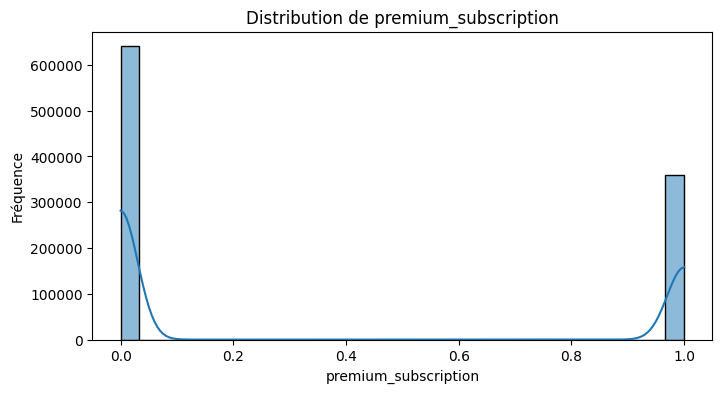

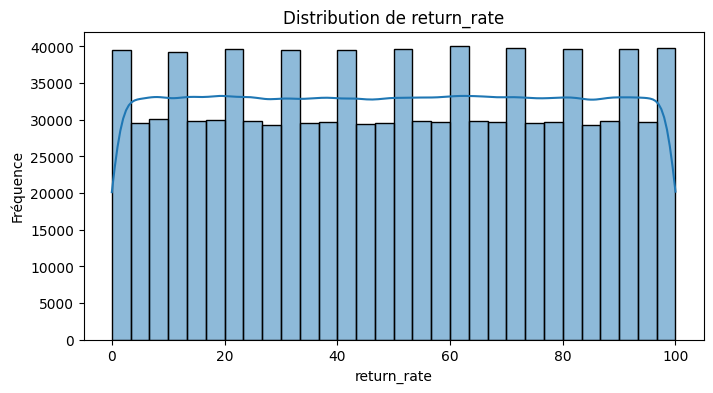

In [14]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

for col in colonnes_numeriques:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

Les données ne suive pas une loi normal, j'ai regardé sur internet pour le e-commerce il dise que c'est courrant